# Imports

In [47]:
import numpy as np
import time
import pyscf
from pyscf import dft, scf
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from pyscf import gto, lo, tools, dft 
import pyscf.mp
import pyscf.ci
import py3Dmol
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 1. SMILES strings

## (a)

COc1cc(C=O)ccc1O

## (b)

Since nodes appear in the string in the order that they are visited by DFS, a 
different root node will produce a different order, and thus a different string.

# 2. PySCF calculations
## (a)

In [16]:
smiles = 'COc1cc(C=O)ccc1O'
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

In [17]:
def show(mol):
    style = 'stick'
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=1000)
    mblock = Chem.MolToMolBlock(mol)
    view = py3Dmol.view(width=200, height=200)
    view.addModel(mblock, 'mol')
    view.setStyle({style:{}})
    view.zoomTo()
    view.show()
show(mol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [18]:
def m2m(mol):
    elements = [atom.GetSymbol() for atom in mol.GetAtoms()]
    coordinates = mol.GetConformer().GetPositions()
    atoms = [(element, coordinate) for element, coordinate in zip(elements, coordinates)]
    
    pyscf_mole = gto.Mole()
    pyscf_mole.atom = atoms
    pyscf_mole.build()

    return pyscf_mole

def rks(mol):    
    mf = dft.RKS(mol)
    mf.run();

In [5]:
rks(m2m(mol))

converged SCF energy = -523.934184341745


## (b)

In [19]:
def make_water(n=3):
    # Function to create a single water molecule
    def h2o():
        mol = Chem.MolFromSmiles('O')
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        return mol
    
    # Create a new empty editable molecule
    water = Chem.RWMol()
    
    # Initialize positions
    x_offset = 100.0  # angstroms
    current_position = 0.0
    
    # Create and position 10 water molecules
    for i in range(n):
        single = h2o()
        conf = single.GetConformer()
        for atom_idx in range(single.GetNumAtoms()):
            pos = conf.GetAtomPosition(atom_idx)
            conf.SetAtomPosition(atom_idx, Chem.rdGeometry.Point3D(pos.x + current_position, pos.y, pos.z))
        water.InsertMol(single)
        current_position += x_offset

    return water

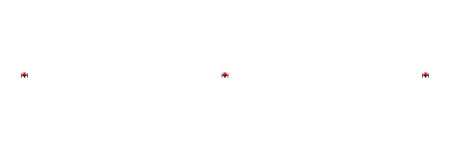

In [20]:
make_water(3)

In [39]:
# do as many as we can until the time runs out
def make_stats(f, maxiter, maxtime_sec):
    loop_start = time.time()
    times = []
    sizes = []
    for i in range(1,maxiter):
        if time.time() - loop_start > maxtime_sec:
            print('tl exceeded')
            break
        mol = make_water(i)
        start = time.time()
    
        f(m2m(mol))
        times.append(time.time() - loop_start)
        sizes.append(i)
    return times, sizes

In [9]:
times, sizes = make_stats(rks, 50, 300)

converged SCF energy = -74.733849459309
converged SCF energy = -149.464891397766
converged SCF energy = -224.203666694875
converged SCF energy = -298.939286536943
converged SCF energy = -373.681327474522
converged SCF energy = -448.408101985058
converged SCF energy = -523.14467951872
converged SCF energy = -597.881454292322
converged SCF energy = -672.616646759054
converged SCF energy = -747.346001449402
converged SCF energy = -822.092950283582
converged SCF energy = -896.797965967826
converged SCF energy = -971.555974201538
converged SCF energy = -1046.25772331709
converged SCF energy = -1121.03400811523
converged SCF energy = -1195.76244328615
converged SCF energy = -1270.48895200062
converged SCF energy = -1345.22915069711
converged SCF energy = -1419.98590433938
converged SCF energy = -1494.69602048063
converged SCF energy = -1569.4315970825
converged SCF energy = -1644.1716839882
converged SCF energy = -1718.896525912
converged SCF energy = -1793.62961428428
converged SCF energy =

In [72]:
def plot_comp(sizes, times, method, loglog=True):
    def exp(x, a, b): return a * (x ** b)
    p, cov = curve_fit(exp, sizes, times)
    plt.plot(sizes, times, label='data')
    plt.plot(sizes, [exp(i, *p) for i in sizes], label='fit')
    title = f'estimated {method} time complexity: {p[0]:.2f}*n^{p[1]:.2f}'
    plt.title(title)
    if loglog:
        plt.gca().set_yscale('log')
        plt.gca().set_xscale('log')
        plt.title(title + ' (log-log)')
    plt.xlabel('number of water molecules')
    plt.ylabel('time')
    plt.legend()
    plt.show()

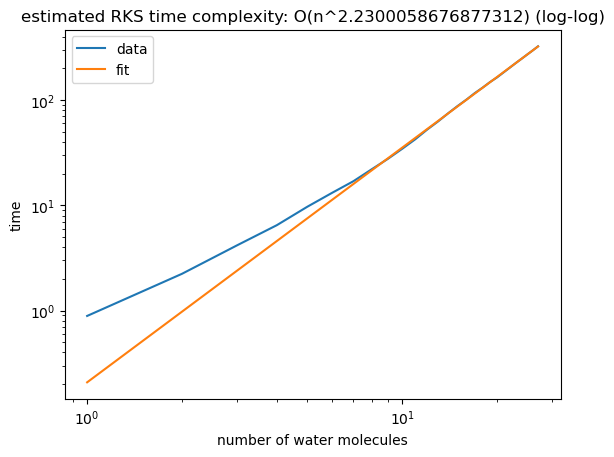

In [11]:
plot_comp(sizes, times, 'RKS')

## (c)

In [48]:
def cisd(mol):
    hf = scf.RHF(mol)
    hf.run()
    # CISD calculation
    pyscf.ci.CISD(hf).run()
    
def mp2(mol):
    hf = scf.RHF(mol)
    hf.run()
    # MP2 calculation
    pyscf.mp.MP2(hf).run()

converged SCF energy = -74.9638507516451
E(RCISD) = -75.01587223566503  E_corr = -0.05202148401992797
converged SCF energy = -149.922678130032
E(RCISD) = -150.0236266129307  E_corr = -0.1009484828984553
converged SCF energy = -224.880540602665
E(RCISD) = -225.0276631406934  E_corr = -0.1471225380286654
converged SCF energy = -299.846106537771
E(RCISD) = -300.0405970384733  E_corr = -0.1944905007022688
converged SCF energy = -374.813334266458
E(RCISD) = -375.0512018495645  E_corr = -0.2378675831066843
converged SCF energy = -449.768721719565
E(RCISD) = -450.0466823409237  E_corr = -0.2779606213590376
converged SCF energy = -524.736280526286
E(RCISD) = -525.0545106621416  E_corr = -0.3182301358553164
converged SCF energy = -599.687258408016
E(RCISD) = -600.0428471734978  E_corr = -0.3555887654816501
converged SCF energy = -674.663236321354
E(RCISD) = -675.0576123496841  E_corr = -0.3943760283297885
converged SCF energy = -749.614400875095
E(RCISD) = -750.0448931577412  E_corr = -0.430492

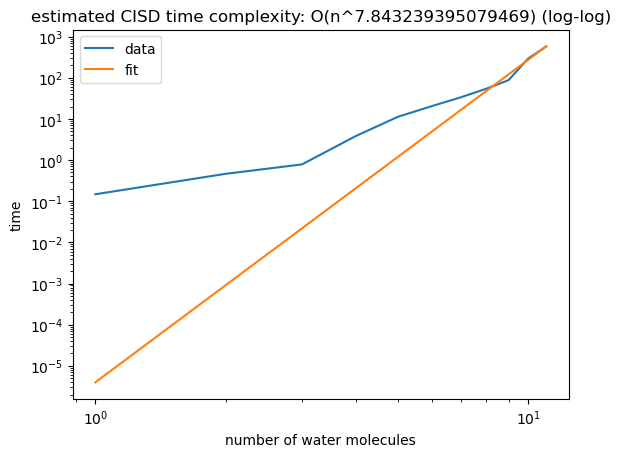

In [59]:
times, sizes = make_stats(cisd, 50, 300)
plot_comp(sizes, times, 'CISD', loglog=False)

converged SCF energy = -74.959676498187
E(MP2) = -74.9972606728617  E_corr = -0.0375841746747832
E(SCS-MP2) = -75.0029940135583  E_corr = -0.043317515371329
converged SCF energy = -149.924737867794
E(MP2) = -150.000322180551  E_corr = -0.0755843127574127
E(SCS-MP2) = -150.011759226558  E_corr = -0.087021358763449
converged SCF energy = -224.885275203303
E(MP2) = -224.997679145571  E_corr = -0.112403942267591
E(SCS-MP2) = -225.014743604545  E_corr = -0.129468401241758
converged SCF energy = -299.850575980703
E(MP2) = -300.001051178891  E_corr = -0.150475198187937
E(SCS-MP2) = -300.023814510018  E_corr = -0.173238529315452
converged SCF energy = -374.804574375491
E(MP2) = -374.99155493126  E_corr = -0.186980555769107
E(SCS-MP2) = -375.019979532361  E_corr = -0.215405156870271
converged SCF energy = -449.767589173258
E(MP2) = -449.992617998319  E_corr = -0.225028825060974
E(SCS-MP2) = -450.026809931525  E_corr = -0.259220758267205
converged SCF energy = -524.723195846785
E(MP2) = -524.984

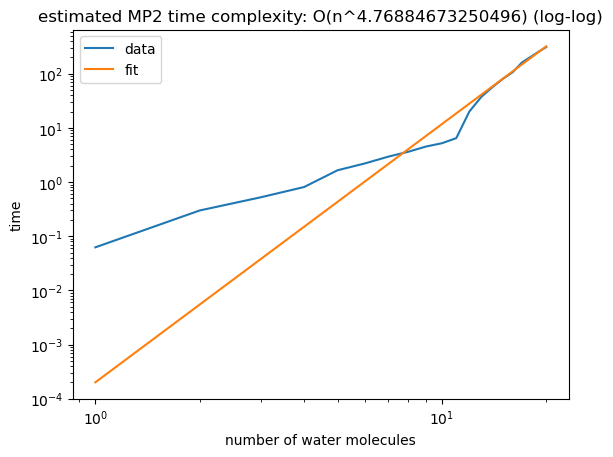

In [50]:
times, sizes = make_stats(mp2, 50, 300)
plot_comp(sizes, times, 'MP2')

## (d)
Each virion has a mass of about 1 fg = $10^{-15}$ g: https://www.pnas.org/doi/full/10.1073/pnas.2024815118

One carbon atom: $2 \cdot 10^{-26}$ g

$0.5 \cdot 10^{11}$ atoms per virion, 4 electrons per atom $\implies$ $2 \cdot 10^{11}$ electrons per virion



In [60]:
times, sizes = make_stats(rks, 10, 300)

converged SCF energy = -74.7331625650387
converged SCF energy = -149.468880683179
converged SCF energy = -224.207580373679
converged SCF energy = -298.941918702306
converged SCF energy = -373.670377952099
converged SCF energy = -448.407109661443
converged SCF energy = -523.137333265435
converged SCF energy = -597.879454497718
converged SCF energy = -672.608260327314


In [70]:
def plot_comp(sizes, times, method, loglog=True):
    def exp(x, a, b): return a * (x ** b)
    p, cov = curve_fit(exp, sizes, times)
    plt.plot(sizes, times, label='data')
    plt.plot(sizes, [exp(i, *p) for i in sizes], label='fit')
    title = f'estimated {method} time complexity: {p[0]:.2f}*n^{p[1]:.2f}'
    plt.title(title)
    if loglog:
        plt.gca().set_yscale('log')
        plt.gca().set_xscale('log')
        plt.title(title + ' (log-log)')
    plt.xlabel('number of water molecules')
    plt.ylabel('time')
    plt.legend()
    plt.show()

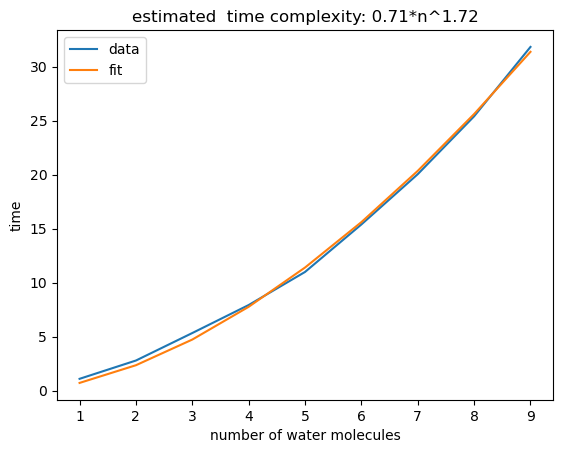

In [71]:
plot_comp(sizes,times,'',False)